In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_direction(xv, yv, num_realiz, nn):
    e, num_its = xv.shape
    totinds = []

    for i in range(num_realiz):
        r = np.random.permutation(num_its)[0]  # Randomly picking an index
        y_nn_inds = sharenn(yv, r, nn)
        totin = get_nn_inds(xv, r, y_nn_inds, nn, num_its)
        totinds.append(totin)

    return np.array(totinds)

def get_nn_inds(yv, r, inds, nn, num_its):
    # Returns the ranks of the nn indexes inds among the num_its points by proximity to yv[r]
    dist = np.zeros(num_its)

    for j in range(num_its):
        dist[j] = np.linalg.norm(yv[:, j] - yv[:, r])

    dist_sorted = np.sort(dist)
    indds = np.argsort(dist)

    totin = []
    for j in range(nn):
        totin.append(np.where(indds == inds[j])[0][0])

    return np.array(totin)

def sharenn(traj, mats, nn):
    e, num_its = traj.shape
    mats = np.unique(mats)
    num_mats1 = len(mats)
    mats_new = []

    for j in range(num_mats1):
        dist = np.zeros(num_its)

        for i in range(num_its):
            dist[i] = np.linalg.norm(traj[:, i] - traj[:, mats[j]])

        dist_sorted = np.sort(dist)
        ind = np.argsort(dist)

        # Skip the first index, which is the closest point (itself)
        mats_new.extend(ind[1:nn + 1])

    return np.array(mats_new)

def make_delay_vectors(x, y, e):
    num_its = len(x)
    num_vecs = num_its - e + 1
    
    # Initialize delay vectors
    xv = np.zeros((e, num_vecs))
    yv = np.zeros((e, num_vecs))
    
    for i in range(num_vecs):
        xv[:, i] = x[i:i + e,0]
        yv[:, i] = y[i:i + e,0]

    return xv, yv

def make_pairs(num_samples, its_per_sample, noise_level, dim, fx, fy, fd, cxy, cxd, cyd, cyx, cdx, cdy):
    pre_its = 5000
    num_its = max(pre_its,num_samples * its_per_sample)
    
    # Initialize arrays
    x = np.zeros((dim[0], num_its))
    y = np.zeros((dim[1], num_its))
    d = np.zeros((dim[2], num_its))
    
    # Random initialization
    x[:, 0] = np.random.rand(dim[0])
    y[:, 0] = np.random.rand(dim[1])
    d[:, 0] = np.random.rand(dim[2])
    
    # Pre-iterations
    for i in range(pre_its - 1):
        d[:, i + 1] = fd(d[:, i]) + cxd @ x[:, i] + cyd @ y[:, i]
        x[:, i + 1] = fx(x[:, i]) + cyx @ y[:, i] + cdx @ d[:, i]
        y[:, i + 1] = fy(y[:, i]) + cxy @ x[:, i] + cdy @ d[:, i]

    # Roll over the last values
    x[:, 0] = x[:, pre_its - 1]
    y[:, 0] = y[:, pre_its - 1]
    d[:, 0] = d[:, pre_its - 1]
    
    # Main iterations
    for i in range(num_its - 1):
        d[:, i + 1] = fd(d[:, i]) + cxd @ x[:, i] + cyd @ y[:, i]
        x[:, i + 1] = fx(x[:, i]) + cyx @ y[:, i] + cdx @ d[:, i]
        y[:, i + 1] = fy(y[:, i]) + cxy @ x[:, i] + cdy @ d[:, i]

    # Adding noise
    x += np.random.randn(*x.shape) * noise_level
    y += np.random.randn(*y.shape) * noise_level
    d += np.random.randn(*d.shape) * noise_level

    # Sampling the output
    x = x[:, :num_its:its_per_sample].T
    y = y[:, :num_its:its_per_sample].T
    d = d[:, :num_its:its_per_sample].T
    
    return x, y, d



def detC(num_samples, its_per_sample, noise_level, dim, fx, fy, fd, cxy, cxd, cyd, cyx, cdx, cdy):
    num_realiz = num_samples - 20
    nn = 12
    sh = np.arange(3, nn + 1)  

    x, y, _ = make_pairs(num_samples, its_per_sample, noise_level, dim, fx, fy, fd, cxy, cxd, cyd, cyx, cdx, cdy)
    
    e = 8
    xv, yv = make_delay_vectors(x, y, e)
    num_vecs = xv.shape[1]

    # Find direction for x vs y
    totinds_sorted = np.sort(find_direction(xv, yv, num_realiz, nn), axis=1)
    r = totinds_sorted * (nn + 1) / np.arange(1, nn + 1) / num_vecs
    p = np.mean(r, axis=0)
    sd = np.std(r, axis=0, ddof=1) / np.sqrt(num_realiz)

    plt.figure(2)
    plt.errorbar(sh + 0.1, p[sh - 3], 3 * sd[sh - 3], fmt='bo', linewidth=2, markersize=5, label='x vs y')

    # Find direction for y vs x
    totinds_sorted = np.sort(find_direction(yv, xv, num_realiz, nn), axis=1)
    r = totinds_sorted * (nn + 1) / np.arange(1, nn + 1) / num_vecs
    p = np.mean(r, axis=0)
    sd = np.std(r, axis=0, ddof=1) / np.sqrt(num_realiz)

    plt.errorbar(sh - 0.1, p[sh - 3], 3 * sd[sh - 3], fmt='ro', linewidth=2, markersize=5, label='y vs x')

    plt.xlim([2, sh[-1] + 1])
    plt.ylim([0, 1.20])
    plt.plot([0, sh[-1] + 1], [1, 1], 'k', linewidth=2)
    plt.xlabel('neighbor number', fontsize=24)
    plt.ylabel('effective proportion', fontsize=24)
    plt.grid(True)
    plt.gca().tick_params(labelsize=24)
    plt.legend(loc = 'center left')
    plt.show()

In [3]:
def dirC(num_samples, its_per_sample, noise_level, dim, fx, fy, fd, cxy, cxd, cyd, cyx, cdx, cdy):
    num_its = num_samples * its_per_sample
    num_realiz = num_its - 20
    nn = 12
    sh = np.arange(3, nn + 1)  # sh = 3:nn
    
    x, y, _ = make_pairs(num_samples, its_per_sample, noise_level, dim, fx, fy, fd, cxy, cxd, cyd, cyx, cdx, cdy)
    e = 12

    rxy = np.zeros((nn))
    ryx = np.zeros((nn))

    xv, yv = make_delay_vectors(x, y, e)
    num_vecs = xv.shape[1]

    totinds = find_direction(xv, yv, num_realiz, nn)
    rxy = np.mean(totinds, axis=0) / num_vecs * 100
    gsxy = np.mean(totinds, axis=0)
    totinds = find_direction(yv, xv, num_realiz, nn)
    ryx = np.mean(totinds, axis=0) / num_vecs * 100
    gsyx = np.mean(totinds, axis=0)
    plt.figure(2)

    cxy = np.polyfit(sh, rxy[sh - 3], 1)  
    plt.plot(sh, rxy[sh - 3], 'bo', linewidth=3, markersize=6)
    plt.plot(sh, cxy[0] * sh + cxy[1], 'b', linewidth=2)
    sxy = rxy[sh - 3] - (cxy[0] * sh + cxy[1])
    sxy = np.dot(sxy, sxy) / (nn - 2 - 2)  # Degrees of freedom
    sxy = np.sqrt(sxy) / np.sqrt(np.dot(sh - np.mean(sh), sh - np.mean(sh))) 

    cyx = np.polyfit(sh, ryx[sh - 3], 1)
    plt.plot(sh, ryx[sh - 3], 'ro', linewidth=3, markersize=6)
    plt.plot(sh, cyx[0] * sh + cyx[1], 'r', linewidth=2)
    syx = ryx[sh - 3] - (cyx[0] * sh + cyx[1])
    syx = np.dot(syx, syx) / (nn - 2 - 2)  # Degrees of freedom
    syx = np.sqrt(syx) / np.sqrt(np.dot(sh - np.mean(sh), sh - np.mean(sh))) 

    plt.xlim([2, sh[-1]])
    plt.ylim([0, 110])
    plt.gca().tick_params(labelsize=24)
    plt.xlabel('neighbor number', fontsize=24)
    plt.ylabel('distance rank (in %)', fontsize=24)
    XYSlope = f'XY Slope = {cxy[0]:.2f}±{3 * sxy:.2f}'
    plt.text(2.5, 80, XYSlope, color='b', fontsize=24)
    YXSlope = f'YX Slope = {cyx[0]:.2f}±{3 * syx:.2f}'
    plt.text(2.5, 65, YXSlope, color='r', fontsize=24)
    plt.grid()
    plt.show()

In [4]:
def lor1(x):
    s = 10
    r = 27
    b = 8 / 3
    p = [s, r, b]
    dt = 0.01
    y = L63Dynamics(x, dt, p)
    return y
def lor2(x):
    s = 10
    r = 27
    b = 8 / 3
    p = [s, r, b]
    dt = 0.01
    y = L63Dynamics(x, dt, p)
    return y
def lor3(x):
    s = 10
    r = 27
    b = 8 / 3
    p = [s, r, b]
    dt = 0.01
    y = L63Dynamics(x, dt, p)
    return y

def L63Dynamics(state, dt, p):
    N = state.shape[0]  # Number of state variables
    substeps = round(dt / 0.01)  # Determine number of substeps
    h = dt / substeps  # Step size for each substep

    for k in range(substeps):
        # RK4 integration
        k1 = h * L63VectorField(state, p)
        k2 = h * L63VectorField(state + k1 / 2, p)
        k3 = h * L63VectorField(state + k2 / 2, p)
        k4 = h * L63VectorField(state + k3, p)
        state += (k1 / 6) + (k2 / 3) + (k3 / 3) + (k4 / 6)  # Update state

    return state

def L63VectorField(state, p):
    """ Lorenz-63 vector field function. """
    s = p[0]  # Parameter s
    r = p[1]  # Parameter r
    b = p[2]  # Parameter b
    ydot = np.zeros_like(state)  # Initialize the rate of change array

    # Lorenz 63 equations
    ydot[0] = s * (-state[0] + state[1])  # dx/dt
    ydot[1] = -state[0] * state[2] + r * state[0] - state[1]  # dy/dt
    ydot[2] = state[0] * state[1] - b * state[2]  # dz/dt

    return ydot

In [5]:
def hen1(x):
    b=np.array([2.2, 2.17])
    c=np.array([.41, .38])
    d=np.array([.19, .23])
    y=np.array([b[0]*np.cos(x[0])+c[0]*x[1]+d[0]*x[2],x[0],b[1]*np.cos(x[2])+c[1]*x[3]+d[1]*x[0],x[2]])
    return y

def hen2(x):
    b=np.array([2.21, 2.16])
    c=np.array([.38, .42])
    d=np.array([.2, .19])
    y=np.array([b[0]*np.cos(x[0])+c[0]*x[1]+d[0]*x[2],x[0],b[1]*np.cos(x[2])+c[1]*x[3]+d[1]*x[0],x[2]])
    return y

def hen3(x):
    b=np.array([2., 2.17])
    c=np.array([.4, .39])
    d=np.array([.21, .19])
    y=np.array([b[0]*np.cos(x[0])+c[0]*x[1]+d[0]*x[2],x[0],b[1]*np.cos(x[2])+c[1]*x[3]+d[1]*x[0],x[2]])
    return y


## Examples

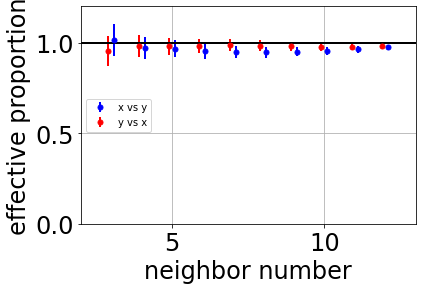

In [6]:
#   Main demo code to call detC for Henon 2-cell

dim = 4
cxy = np.zeros((dim, dim))
cxd = np.zeros((dim, dim))
cyd = np.zeros((dim, dim))
cyx = np.zeros((dim, dim))
cdx = np.zeros((dim, dim))
cdy = np.zeros((dim, dim))

# Setting specific matrix values
cxy[1, 0] = 0.01  # X drives Y; cxy[a,b] means Y coord a driven by X coord b
cyx[1, 0] = 0.0   # Y drives X; cyx[a,b] means X coord a driven by Y coord b
detC(1000,1,0,np.array([1, 1, 1])*dim,hen1,hen2,hen3,cxy,cxd,cyd,cyx,cdx,cdy)

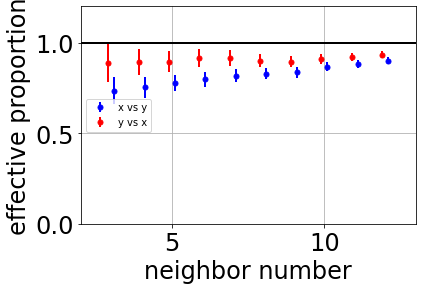

In [7]:
#   Main demo code to call detC for Lorenz

dim = 3
cxy = np.zeros((dim, dim))
cxd = np.zeros((dim, dim))
cyd = np.zeros((dim, dim))
cyx = np.zeros((dim, dim))
cdx = np.zeros((dim, dim))
cdy = np.zeros((dim, dim))

# Setting specific matrix values
cxy[1, 0] = 0.1  # X drives Y
cyx[1, 0] = 0.0   # Y drives X
detC(1000,10,0,np.array([1, 1, 1])*dim,lor1,lor2,lor3,cxy,cxd,cyd,cyx,cdx,cdy)

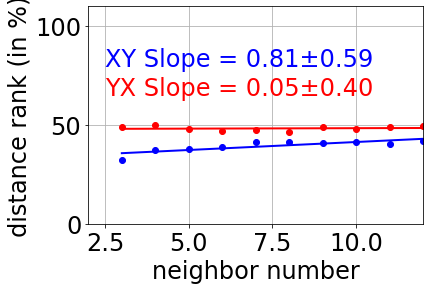

In [8]:
#   Main demo code to call dirC for Henon 2-cell

dim = 4 # dimension of dynamical system -- 4 for Henon
cxy = np.zeros((dim, dim))
cxd = np.zeros((dim, dim))
cyd = np.zeros((dim, dim))
cyx = np.zeros((dim, dim))
cdx = np.zeros((dim, dim))
cdy = np.zeros((dim, dim))

# Setting specific matrix values
cxy[1, 0] = 0.1  # X drives Y
cyx[1, 0] = 0.0   # Y drives X
dirC(1000,1,0,np.array([1, 1, 1])*dim,hen1,hen2,hen3,cxy,cxd,cyd,cyx,cdx,cdy)

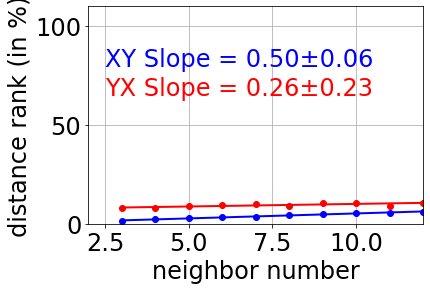

In [10]:
#   Main demo code to call dirC for Lorenz

dim = 3   # dimension of dynamical system - 3 for Lorenz63
cxy = np.zeros((dim, dim))
cxd = np.zeros((dim, dim))
cyd = np.zeros((dim, dim))
cyx = np.zeros((dim, dim))
cdx = np.zeros((dim, dim))
cdy = np.zeros((dim, dim))

# Setting specific matrix values
cxy[1, 0] = 0.1  # X drives Y
cyx[1, 0] = 0.0   # Y drives X
dirC(1000,10,0,np.array([1, 1, 1])*dim,lor1,lor2,lor3,cxy,cxd,cyd,cyx,cdx,cdy)

In [ ]:
#   Demo code to call detC and dirC for Henon 2-cell

dim = 4
cxy = np.zeros((dim, dim))
cxd = np.zeros((dim, dim))
cyd = np.zeros((dim, dim))
cyx = np.zeros((dim, dim))
cdx = np.zeros((dim, dim))
cdy = np.zeros((dim, dim))

# Setting specific matrix values
cdx[1, 0] = 0.8  # D drives X; cdx[a,b] means X coord a driven by D coord b
cdy[1, 0] = 0.8   # D drives Y; cdy[a,b] means Y coord a driven by D coord b
detC(1000,1,0,np.array([1, 1, 1])*dim,hen1,hen2,hen3,cxy,cxd,cyd,cyx,cdx,cdy)
dirC(1000,1,0,np.array([1, 1, 1])*dim,hen1,hen2,hen3,cxy,cxd,cyd,cyx,cdx,cdy)

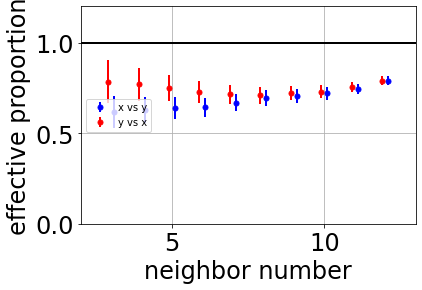

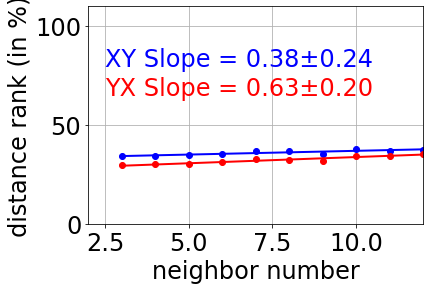

In [16]:
#   Demo code to call detC and dirC for Lorenz

dim = 3   # dimension of dynamical system - 3 for Lorenz63
cxy = np.zeros((dim, dim))
cxd = np.zeros((dim, dim))
cyd = np.zeros((dim, dim))
cyx = np.zeros((dim, dim))
cdx = np.zeros((dim, dim))
cdy = np.zeros((dim, dim))

# Setting specific matrix values
cdx[1, 0] = 0.04   # D drives X; cdx[a,b] means X coord a driven by D coord b
cdy[1, 0] = 0.04   # D drives Y; cdy[a,b] means Y coord a driven by D coord b
detC(1000,10,0,np.array([1, 1, 1])*dim,lor1,lor2,lor3,cxy,cxd,cyd,cyx,cdx,cdy)
dirC(2000,10,0,np.array([1, 1, 1])*dim,lor1,lor2,lor3,cxy,cxd,cyd,cyx,cdx,cdy)